<a href="https://colab.research.google.com/github/szucshey/osm-data-exploration/blob/main/climate/climate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install folium osm2geojson geopandas regionmask --quiet

In [2]:
import folium
import requests
import json
import osm2geojson
import geopandas as gpd
import matplotlib.pyplot as plt


In [3]:
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
    [out:json];
    rel["ISO3166-1"~"^HU"]
    [admin_level=2]
    [type=boundary]
    [boundary=administrative];
    out geom;
    """

response = requests.get(overpass_url, params={'data': overpass_query})

#Az API válasz lementése egy json fileba
output = open("geojson.json", "w")
json.dump(response.json(), output)
output.close()

In [4]:
data = json.load(open("geojson.json", "r"))
geojson = osm2geojson.json2geojson(data)

#m = folium.Map(location=[47.161, 19.505], zoom_start=8, min_zoom=7, maxBounds=[[40.000, 10.000], [60.000, 30.000]], tiles=None, attr="", prefer_canvas=True, overlay=True)
#m.add_child(folium.GeoJson(geojson, name='geojson'))

#m

In [5]:
gdf = gpd.GeoDataFrame.from_features(geojson)

In [6]:
import xarray as xr
import regionmask
import numpy as np

#lon = np.arange(15, 24)
#lat = np.arange(45, 50)

#mask = regionmask.mask_geopandas(gdf, lon, lat)
mask1 = regionmask.Regions(gdf['geometry'])
mask1

<regionmask.Regions>
Name:     unnamed
overlap:  False

Regions:
0 r0 Region0

[1 regions]

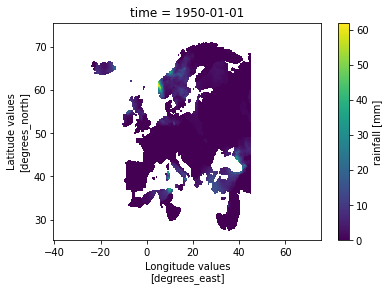

In [7]:
ds = xr.open_dataarray("rr_ens_mean_0.25deg_reg_v25.0e.nc")
ds.isel(time = 0).plot()

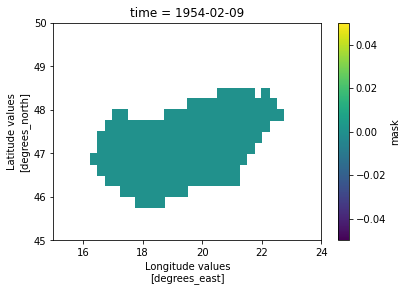

In [12]:
mask = mask1.mask(ds.isel(time = 1500), lat_name = 'latitude', lon_name = 'longitude')
mask.plot(xlim=[15,24], ylim=[45,50])

In [16]:
mask.to_netcdf("rr_hungary.nc")
mask = xr.open_dataarray("rr_hungary.nc")

In [18]:
mask_shape = mask.where(mask == 0)

In [20]:
mask

<xarray.DataArray 'mask' (latitude: 201, longitude: 464)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * latitude   (latitude) float64 25.38 25.62 25.88 26.12 ... 74.88 75.12 75.38
  * longitude  (longitude) float64 -40.38 -40.12 -39.88 ... 74.88 75.12 75.38